In [421]:
import cv2
def rotate(im, angle, center=None):
    """
    rotate an image `angle` degrees counterclockwise about `center`
    :param im (h, w, c) array
    :param angle (float) angle in degrees
    :param center (optional) point in image coordinates to rotate about
    """
    h, w = im.shape[:2]
    if center is None:
        center = (w // 2, h // 2)
    mat = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
    print (mat)
    return cv2.warpAffine(im, mat, (w, h))

def translate_no_pad(im, translation):
    """
    translate an image `tx` to the right, `ty` down
    :param image (h, w, c) array
    :param tx (float) pixels to translate right
    :param ty (float) pixels to translate down
    """
    ty, tx = translation
    h, w = im.shape[:2]
    mat = translation_matrix = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)
    return cv2.warpAffine(im, mat, (w, h))

In [778]:
import matplotlib.pyplot as plt
import numpy as np
import os

img_dir = 'data/'
out_dir = 'out_path/'

def read_img(img_name):
    img = plt.imread(img_dir + img_name)
    img = img / 255
    if '.tif' in img_name:
        img /= 255
    return img

# translates the image with a circular shift, where translation = (dh, dw)
def translate_circ(img, translation):
    return np.roll(np.roll(img, translation[0], axis=0), translation[1], axis=1)

def split_into_channels(img):
    # compute the height of each part (just 1/3 of total)
    height = np.floor(img.shape[0] / 3.0).astype(np.int_)

    # separate color channels
    b, g, r = img[:height], img[height: 2*height], img[2*height: 3*height]
    return r, g, b

# computes ssd score between two images
def ssd(img1, img2):
    ssd_score = sum((img1 - img2)**2)
    return ssd_score

# computes the normalized cross correlation, by first demeaning and normalizing
def ncc(img_1, img_2):
    n1 = img_1-np.mean(img_1)
    n2 = img_2-np.mean(img_2)
    n1 = n1 / np.sqrt(np.sum(n1**2))
    n2 = n2 / np.sqrt(np.sum(n2**2))
    return -np.sum(img_1*img_2)
    
# brute force algorithm which searches in the [min_tr, max_tr) space for the translation
# and calculates the similarity score based on a metric
def naive_align_two_channels(c1, c2, metric, min_tr_h=-15, max_tr_h=15, min_tr_w=-15, max_tr_w=15):
    min_score = float('inf')
    translation = 0, 0
    for u in range(min_tr_h, max_tr_h):
        for v in range(min_tr_w, max_tr_w):
            test_trans = (u,v)
            c1_trans = translate(c1, test_trans)
            s = metric(c1_trans, c2)
            if s < min_score:
                translation = test_trans
                min_score = s
    return translation, min_score

# stacks the channels to get an RGB image
def stack_channels(r, g, b):
    img_out = np.dstack([r, g, b])
    return img_out

translate = translate_circ

# aligns images by a hard-coded translation
def process_hard_coded(r, g, b, trans_r, trans_g):
    r = translate(r, trans_r)
    g = translate(g, trans_g)
    img_aligned = stack_channels(r, g, b)
    return img_aligned

# naively crops the image by ratio percentage from the left/right sides
def crop_border(img, ratio = 0.2):
    h, w = img.shape[:2]
    return img[int(h*(ratio/2)):int(h*(1-ratio/2)), int(w*(ratio/2)):int(w*(1-ratio/2))]
    
def process_single_scale(img, metric = None, crop = False):
    r, g, b = split_into_channels(img)
    trans_r, trans_g = (0,0), (0,0)
    if metric:
        r_cr, g_cr, b_cr = r, g, b
        if crop:
            r_cr, g_cr, b_cr = map(crop_border, (r, g, b))
        trans_r, _ = naive_align_two_channels(r_cr, b_cr, metric)
        trans_g, _ = naive_align_two_channels(g_cr, b_cr, metric)

        r = translate(r, trans_r)
        g = translate(g, trans_g)
    img_aligned = stack_channels(r, g, b)
    return img_aligned, trans_r, trans_g

def save_img(fname, img_out):
    img_out = (img_out*255).astype(np.uint8)
    plt.imsave(out_dir + fname, img_out)

In [787]:
### Multiscale Pyramid Algorithm
import skimage
import math

min_size, max_size = 400, 1000
h, w = 3000, 3025

def pyramid_align_image(r, g, b, metric):
    min_size, max_size = 400, 4000
    resize_ratio = 2
    h, w = r.shape[:2]
    print(h, w)
    num_times_downscale = max(math.floor(math.log2(h/min_size)), math.floor(math.log2(w/min_size)))
    scale_factor = pow(1/resize_ratio, num_times_downscale)
    
    num_pyramid_search = 0
    start_search_space = (-20, 20)
    min_r_score, min_g_score = float('inf'), float('inf')
    best_trans_r, best_trans_g = (0,0), (0,0)
    
    min_tr_r_h, max_tr_r_h = (0,0)
    min_tr_r_w, max_tr_r_w = (0,0)
    
    min_tr_g_h, max_tr_g_h = (0,0)
    min_tr_g_w, max_tr_g_w = (0,0)
    print(num_times_downscale)
    refine = 2
    
    while scale_factor * h < max_size and scale_factor * w < max_size and num_times_downscale - num_pyramid_search >= 0:
        num_pyramid_search += 1
        print('scale factor:', scale_factor, 'num pyramid search:', num_pyramid_search, scale_factor * h, scale_factor * w)
        r_rs = skimage.transform.rescale(r, scale_factor, anti_aliasing=False)
        g_rs = skimage.transform.rescale(g, scale_factor, anti_aliasing=False)
        b_rs = skimage.transform.rescale(b, scale_factor, anti_aliasing=False)
        
        min_tr_r_h, max_tr_r_h = start_search_space if num_pyramid_search == 1 else (best_trans_r[0]-refine, best_trans_r[0]+refine)
        min_tr_r_w, max_tr_r_w = start_search_space if num_pyramid_search == 1 else (best_trans_r[1]-refine, best_trans_r[1]+refine)
        min_tr_g_h, max_tr_g_h = start_search_space if num_pyramid_search == 1 else (best_trans_g[0]-refine, best_trans_g[0]+refine)
        min_tr_g_w, max_tr_g_w = start_search_space if num_pyramid_search == 1 else (best_trans_g[1]-refine, best_trans_g[1]+refine)
                
        best_trans_r, min_r_score = naive_align_two_channels(r_rs, b_rs, metric, min_tr_r_h, max_tr_r_h, min_tr_r_w, max_tr_r_w)
        best_trans_g, min_g_score = naive_align_two_channels(g_rs, b_rs, metric, min_tr_g_h, max_tr_g_h, min_tr_g_w, max_tr_g_w)
        print('cur: ', trans_r, min_r_score, trans_g, min_g_score)

        
        scale_factor *= resize_ratio
        if num_times_downscale - num_pyramid_search >= 0:
            best_trans_r = best_trans_r[0] * 2, best_trans_r[1] * 2
            best_trans_g = best_trans_g[0] * 2, best_trans_g[1] * 2
        print('best: ', best_trans_r, best_trans_g)
    
    print(num_times_downscale, num_pyramid_search)
    while num_times_downscale - num_pyramid_search > 0:
        num_pyramid_search += 1
        best_trans_r = best_trans_r[0] * 2, best_trans_r[1] * 2
        best_trans_g = best_trans_g[0] * 2, best_trans_g[1] * 2
        
    return best_trans_r, best_trans_g
      
    
def process_pyramid_scale(img, metric = None, crop = False):
    r, g, b = split_into_channels(img)
    trans_r, trans_g = (0,0), (0,0)
    if metric:
        r_cr, g_cr, b_cr = r, g, b
        if crop:
            r_cr, g_cr, b_cr = map(crop_border, (r, g, b))
        trans_r, trans_g = pyramid_align_image(r, g, b, ssd)
        r = translate(r, trans_r)
        g = translate(g, trans_g)
    img_aligned = stack_channels(r, g, b)
    return img_aligned, trans_r, trans_g

translate = translate_circ
img_name = 'church.tif'
img = read_img(img_name)
img_aligned, trans_r, trans_g = process_pyramid_scale(img, ssd)
img_aligned = np.clip(img_aligned, 0, 1)
plt.imshow(img_aligned)
print(trans_r, trans_g)
# plt.imsave('out/pyramid/' + 'church.jpg', img_aligned)


3202 3634
3
scale factor: 0.125 num pyramid search: 1 400.25 454.25
cur:  (52, -6) 12487.29217286253 (0, -5) 10924.685294371771
best:  (12, -2) (0, -2)
scale factor: 0.25 num pyramid search: 2 800.5 908.5
cur:  (52, -6) 49648.46158964443 (0, -5) 43216.89484455543
best:  (26, -4) (0, -2)
scale factor: 0.5 num pyramid search: 3 1601.0 1817.0
cur:  (52, -6) 198747.30880890568 (0, -5) 173174.19414264415
best:  (52, -6) (0, -6)
scale factor: 1.0 num pyramid search: 4 3202.0 3634.0


In [784]:
r, g, b = split_into_channels(img)
r_cr, g_cr, b_cr = map(crop_border, (r, g, b))
print(naive_align_two_channels(r_cr, b_cr, ssd, 45, 60, -10, 0))


((58, -4), 475482.8951505567)
((25, 4), 402382.11560012423)


In [ ]:
print(naive_align_two_channels(g_cr, b_cr, ssd, 20, 30, -10, 10))

(12, 3) (5, 2)


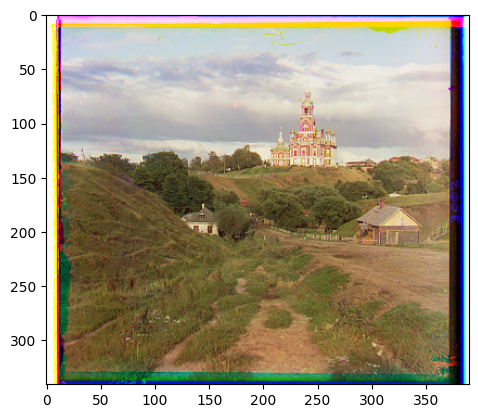

In [737]:
translate = translate_circ
img_name = 'cathedral.jpg'
img = read_img(img_name)
r, g, b = split_into_channels(img)
r_cr, g_cr, b_cr = map(crop_border, (r, g, b))

img_aligned, trans_r, trans_g = process_single_scale(img, ssd, crop=True)
plt.imshow(img_aligned)
print(trans_r, trans_g)

In [676]:
img_name = 'emir.tif'
img = read_img(img_name)

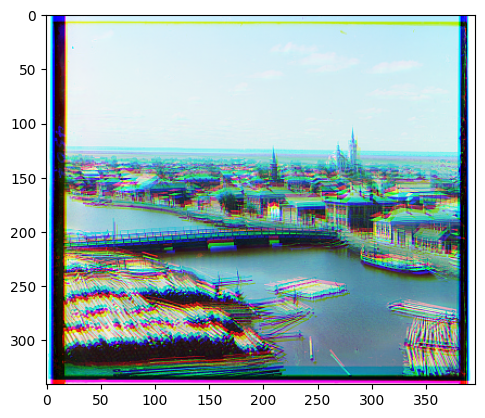

In [571]:
img_def, _, _ = process(img)
plt.imshow(img_def)

In [721]:
img_name = 'cathedral.jpg'
img = read_img(img_name)

(7, -1) (7, -1) (341, 390, 3)


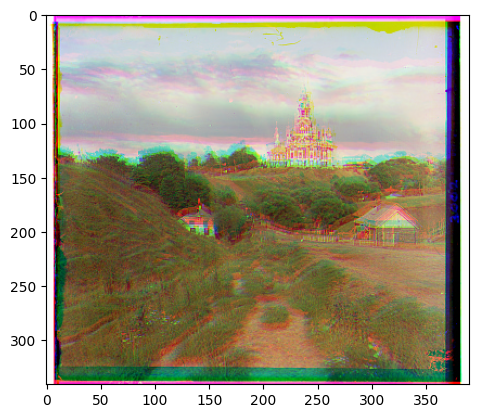

In [722]:
translate = translate_circ
img_aligned, trans_r, trans_g = process_single_scale(img, metric=ssd, crop=True)
plt.imshow(img_aligned)
print(trans_r, trans_g,img_aligned.shape)

In [691]:
out_dir = 'out/ncc'
for img_name in os.listdir('data'):
    if '.jpg' in img_name:
        img = read_img(img_name)
        print(img_name)
        translate = translate_circ
        img_aligned, trans_r, trans_g = process_single_scale(img, metric=ssd, crop=True)
        post_cr = crop_border(img_aligned, 0.1)
        # plt.imshow(img_aligned)
        print(trans_r, trans_g, img_aligned.shape)
        # plt.imsave(out_dir + img_name, img_aligned)


monastery.jpg
(3, 2) (-3, 2) (341, 391, 3)
tobolsk.jpg
(6, 3) (3, 3) (341, 396, 3)
cathedral.jpg
(12, 3) (5, 2) (341, 390, 3)


(6, 3) (3, 2) (306, 357, 3)


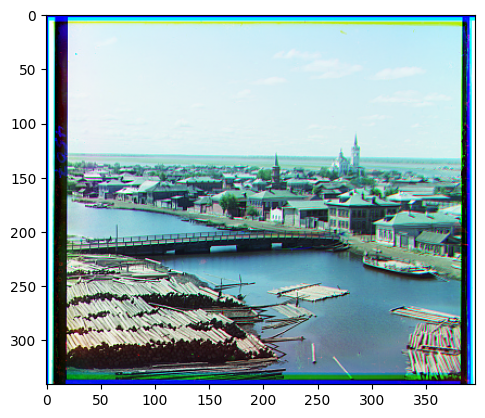

In [585]:
#use_pre_crop False, post_crop
translate = translate_no_pad
img_aligned, trans_r, trans_g = process(img, align_func=naive_align_two_channels, metric=ssd, crop=True)
post_cr = crop_border(img_aligned, 0.1)
plt.imshow(img_aligned)
print(trans_r, trans_g, post_cr.shape)